# Benchmarking: Visualize Train Performance
## Select Env

In [1]:
import sys
from pathlib import Path
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import OrderedDict
from tqdm import tqdm
import pandas as pd
import wandb
import sys
sys.path.append("../..")
import pandas as pd
import ast
from rich import print as printr
from rich.progress import track
from ast import literal_eval
from pathlib import Path
from omegaconf import OmegaConf
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def get_eval_data_fn(outdir: str | Path, env_name: str):
    outdir = Path(outdir)
    eval_data_fn = outdir / f"eval_data/{env_name}.pickle"
    eval_data_fn.parent.mkdir(parents=True, exist_ok=True)
    return eval_data_fn


def get_plot_data_fn(eval_data_fn: str | Path):
    eval_data_fn = Path(eval_data_fn)
    plot_data_fn = Path(eval_data_fn).parent / (Path(eval_data_fn).stem + "_plot.csv")
    plot_data_fn.parent.mkdir(parents=True, exist_ok=True)
    return plot_data_fn


sys.path.append("/home/benjamin/Dokumente/code/tmp/tntcomp/CARL")

# env_name = "CARLMountainCarEnv"
env_name = "CARLPendulumEnv"
# env_name = "CARLAcrobotEnv"
# env_name = "CARLDmcWalkerEnv"
# env_name = "CARLDmcQuadrupedEnv"
# env_name = "CARLCartPoleEnv"
# env_name = "CARLBipedalWalkerEnv"
# env_name = "CARLMountainCarEnv"
# env_name = "CARLLunarLanderEnv"
outdir = Path("/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/experiments/evaluation/data/")
outdir.mkdir(parents=True, exist_ok=True)
figoutdir = outdir / "figures"
figoutdir.mkdir(parents=True, exist_ok=True)

eval_data_fn = get_eval_data_fn(outdir=outdir, env_name=env_name)
plot_data_fn = get_plot_data_fn(eval_data_fn=eval_data_fn)

config_keys = ["wandb.group", "seed", "context_sampler.sigma_rel", "context_sampler.context_feature_names", "context_sampler.uniform_bounds_rel"]

wandb_key_translator = {
    "wandb.group": "visibility",
    "context_sampler.sigma_rel": "$\sigma_{rel}$",
    "context_sampler.context_feature_names": "C",
    "train/global_step": "$k$",
    "eval/return": "$R$",
    "seed": "seed",
    "context_sampler.uniform_bounds_rel": "$\Delta_{rel}$"
}
wkt = wandb_key_translator

errorbar = "ci"


def get_palette_visibility(df: pd.DataFrame) -> dict:
    key = "wandb.group" if "wandb.group" in df else wkt["wandb.group"]
    unique = df[key].unique()
    palette = dict(zip(unique, sns.color_palette(palette="colorblind", n_colors=len(unique))))
    return palette


def load_plot_df(plot_data_fn: str, load_final: bool = False) -> pd.DataFrame:
    plot_df = pd.read_csv(plot_data_fn)
    plot_df.rename(columns=wandb_key_translator, inplace=True)
    plot_df.sort_values(by=[wkt["wandb.group"], wkt["context_sampler.context_feature_names"]], inplace=True)
    if load_final:
        n_steps = plot_df[wkt["train/global_step"]].nunique()
        if n_steps < 1000:
            plot_df = plot_df[plot_df[wkt["train/global_step"]] == plot_df[wkt["train/global_step"]].max()]
        else:
            # wandb logging messed up so we need to gather the last step per run
            group_keys = [wkt["wandb.group"], wkt["context_sampler.context_feature_names"], wkt["seed"], wkt["context_sampler.sigma_rel"], wkt["context_sampler.uniform_bounds_rel"]]
            plot_df = plot_df.groupby(group_keys).apply(lambda x: x[x[wkt["train/global_step"]] == x[wkt["train/global_step"]].max()]).reset_index(drop=True)
            plot_df[wkt["train/global_step"]] = int(round(plot_df[wkt["train/global_step"]].unique().mean(), -5))

        plot_df = scale(plot_df, yname=wkt["eval/return"], log=False)
        plot_df = scale(plot_df, yname=wkt["eval/return"], log=True)
    # if plot_df[wkt["train/global_step"]].nunique() > 200:
    #     plot_df = harmonize_steps(plot_df)

    if wkt["context_sampler.uniform_bounds_rel"] in plot_df:
        key = wkt["context_sampler.uniform_bounds_rel"]
        replacements = {
            "[0.9, 1.1]": 0.1,
            "[0.75, 1.25]": 0.25,
            "[0.5, 1.5]": 0.5,
        }
        
        for before, after in replacements.items():
            plot_df[key][plot_df[key] == before] = after

    return plot_df


def scale(data, yname=wkt["eval/return"], log: bool = True):
    X = data[yname].to_numpy(dtype=float)
    # log_regret = np.log(X + 1e-10)
    # xmax = log_regret.max()
    # xmin = log_regret.min()
    xmax = X.max()
    xmin = X.min()
    # if xmin == -np.inf:
    #     xmin = -50
    def scaler(x):
        # x = np.log(x + 1e-10)
        x = (x - xmin) / (xmax - xmin)
        if log:
            x = np.log(x + 1e-12)
        return x

    identifier = "_scaled"
    if log:
        identifier += "_log"
    data[yname + identifier] = data[yname].apply(scaler)
    return data


def fill_trajectory(performance_list, time_list, replace_nan=np.NaN):
    # If the performance list contains only one list of performances:
    # No need to fill/adjust trajectories bc there is only one.
    if len(performance_list) < 2:
        return np.array(performance_list), np.array(time_list).flatten()

    frame_dict = OrderedDict()
    counter = np.arange(0, len(performance_list))
    for p, t, c in zip(performance_list, time_list, counter):
        if len(p) != len(t):
            raise ValueError(f"({c}) Array length mismatch: {len(p)} != {len(t)}")
        frame_dict[str(c)] = pd.Series(data=p, index=t)

    merged = pd.DataFrame(frame_dict)
    merged = merged.interpolate(method="index")

    performance = merged.to_numpy()
    time_ = merged.index.values

    performance[np.isnan(performance)] = replace_nan
    if not np.isfinite(performance).all():
        raise ValueError("\nCould not merge lists, because \n"
                         "\t(a) one list is empty?\n"
                         "\t(b) the lists do not start with the same times and"
                         " replace_nan is not set?\n"
                         "\t(c) replace_nan is not set and there are non valid "
                         "numbers in the list\n"
                         "\t(d) any other reason.")

    return performance, time_

def harmonize_steps(plot_df: pd.DataFrame) -> pd.DataFrame:
    group_keys = [wkt.get(k,k) for k in config_keys]
    groups = plot_df.groupby(group_keys)
    performance_list, time_list, meta_list = [], [], []
    for group_id, group_df in groups:
        time_list.append(group_df[wkt["train/global_step"]].to_numpy())
        performance_list.append(group_df[wkt["eval/return"]].to_numpy())
        meta_list.append(group_id)

    for i in time_list:
        i[0] = 10000
    performance_list_transformed, time_list_transformed = fill_trajectory(performance_list=performance_list, time_list=time_list)


    plot_df_transformed = pd.DataFrame({
        wkt["train/global_step"]: np.concatenate([time_list_transformed] * performance_list_transformed.shape[-1]),
        wkt["eval/return"]: performance_list_transformed.flatten('F'),
    })

    n_points = performance_list_transformed.shape[0]
    tiles = np.concatenate([np.tile(meta_list[i], n_points).reshape(-1, len(meta_list[i])) for i in range(len(meta_list))])
    for i, k in enumerate(group_keys):
        plot_df_transformed[k] = tiles[:, i]
    return plot_df_transformed


def load_runs_from_wandb(env_name: str, eval_data_fn: str | Path, reload: bool = False) -> pd.DataFrame:
    eval_data_fn = Path(eval_data_fn)
    if not eval_data_fn.is_file():
        reload = True

    if reload:
        api = wandb.Api()

        # Project is specified by <entity/project-name>
        filters = {
            "config.env": env_name,
            "config.experiment": "benchmarking_u",
            "config.wandb.job_type": "train",
            "config.wandb.tags": ["rerun"],
            # "config.context_sampler.n_samples": 1000,
            "state": "finished",
            "config.algorithm": "td3",  # TODO adjust
        }
        printr("Current filters:")
        printr(filters)
        metrics = ["eval/return", "train/global_step"]
        runs = api.runs("tnt/carl-tmlr", filters=filters)

        summary_list, config_list, name_list, metrics_list = [], [], [], []
        for run in tqdm(runs, total=len(runs)):
            # Check metrics first. If not all available, do not append run
            rows = []
            for i, row in run.history(keys=metrics).iterrows():
                if all([metric in row for metric in metrics]):
                    # df = df.append(row, ignore_index=True)
                    rows.append(row)
                else:
                    continue
            df = pd.DataFrame(rows)
            metrics_list.append(df)
            
            # .summary contains the output keys/values for metrics like accuracy.
            #  We call ._json_dict to omit large files
            summary_list.append(run.summary._json_dict)

            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config_list.append(
                {k: v for k,v in run.config.items()
                if not k.startswith('_')})

            # .name is the human-readable name of the run.
            name_list.append(run.name)


        runs_df = pd.DataFrame({
            "summary": summary_list,
            "config": config_list,
            "name": name_list,
            "metrics": metrics_list,
            })

        runs_df.to_pickle(eval_data_fn)
    else:
        runs_df = pd.read_pickle(eval_data_fn)
    return runs_df

def convert_runs_to_plot_data(runs_df: pd.DataFrame, plot_data_fn: str, config_keys: list[str]) -> pd.DataFrame:
    plot_df = []
    for idx, content in tqdm(runs_df.iterrows(), total=len(runs_df)):
        cfg = OmegaConf.create(content["config"])
        scope = locals()
        config_entries = {k: eval("cfg." + k, scope) for k in config_keys}
        metrics = content["metrics"]
        n_points = len(metrics)
        for k, v in config_entries.items():
            metrics[k] = [v] * n_points
        plot_df.append(metrics)

    plot_df = pd.concat(plot_df)
    plot_df.to_csv(plot_data_fn, index=False)
    print("N points", len(plot_df))
    return plot_df


## Download and Convert Data
Download runs from wandb and convert to sth plottable.

In [3]:
runs_df = load_runs_from_wandb(env_name=env_name, eval_data_fn=eval_data_fn, reload=True)
plot_df = convert_runs_to_plot_data(runs_df=runs_df, plot_data_fn=plot_data_fn, config_keys=config_keys)

Current filters:

{
    'config.env': 'CARLPendulumEnv',
    'config.experiment': 'benchmarking_u',
    'config.wandb.job_type': 'train',
    'config.wandb.tags': ['rerun'],
    'state': 'finished',
    'config.algorithm': 'td3'
}

100%|██████████| 510/510 [00:04<00:00, 116.77it/s]


N points 5100


In [4]:
# Print unique rundirs
runs_df = load_runs_from_wandb(env_name=env_name, eval_data_fn=eval_data_fn, reload=False)
rundirs = [cfg.get("rundir", None) for cfg in runs_df["config"]]
rundirs = [r for r in rundirs if r is not None]
import numpy as np
np.unique(rundirs)
# for cfg in runs_df["config"]:
#     print(cfg["rundir"])
#     break

array(['/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-01-05/09-01-41_benchmark_train'],
      dtype='<U92')

## Save Run Specification

In [5]:
plot_df = load_plot_df(plot_data_fn=plot_data_fn)
plot_df

experiment_design = {v: list(plot_df[v].unique()) for k, v in wkt.items() if k not in ["train/global_step", "eval/return"]}
for k, v in experiment_design.items():
    v.sort()

del experiment_design[wkt["context_sampler.sigma_rel"]]
experiment_design["$n_{seeds}$"] = len(experiment_design["seed"])
del experiment_design["seed"]
experiment_design["env"] = env_name

experiment_design = pd.Series(experiment_design)

printr(experiment_design.to_latex())

/tmp/ipykernel_3051/1260046923.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_3051/1260046923.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_3051/1260046923.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after


\begin{tabular}{ll}
\toprule
{} &                                                 0 \\
\midrule
visibility     &      \\
C              &  [['dt'], ['g'], ['l'], ['m'], ['max\_speed'], []] \\
\$\textbackslash Delta\_\{rel\}\$ &                                  [0.1, 0.25, 0.5] \\
\$n\_\{seeds\}\$    &                                                10 \\
env            &                                   CARLPendulumEnv \\
\bottomrule
\end{tabular}

## Plot Combined, Learning Curve

/tmp/ipykernel_30976/2915522875.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_30976/2915522875.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_30976/2915522875.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after


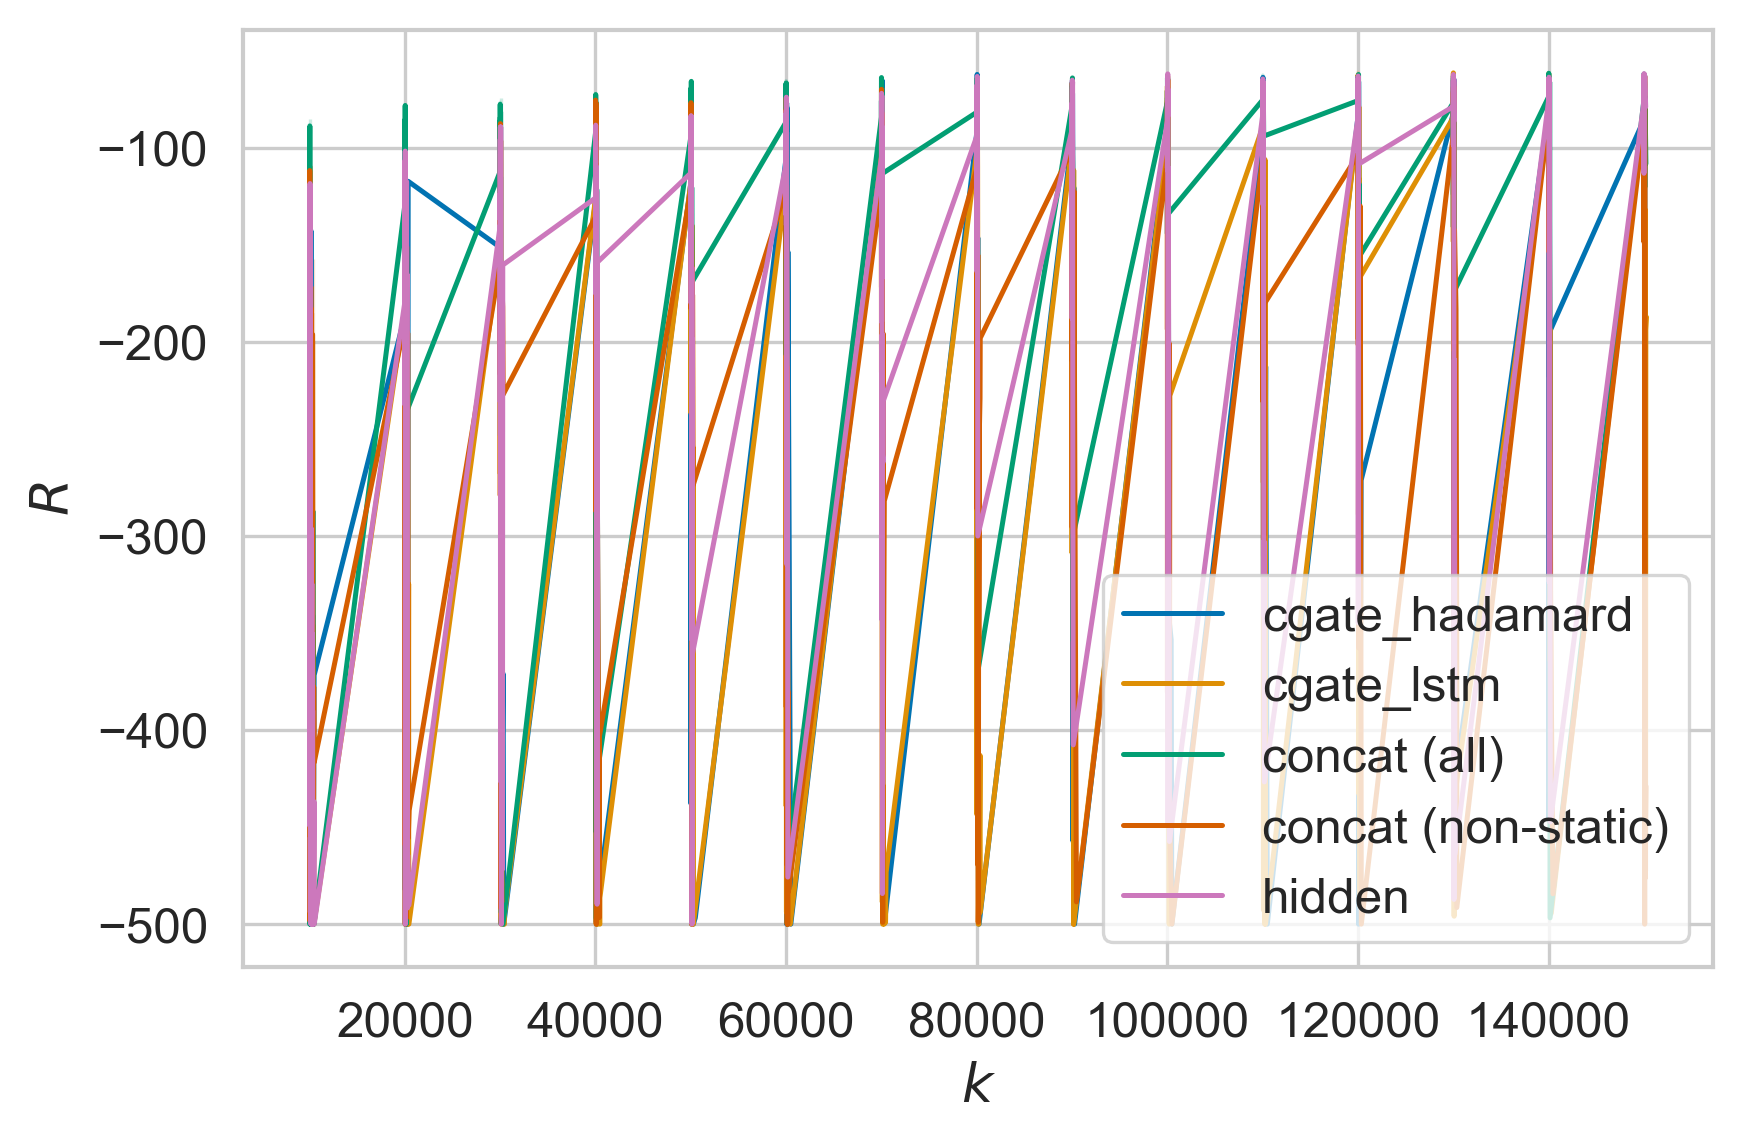

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig_fn = figoutdir / f"{env_name}_deltarel.png"

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.35)

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
palette = get_palette_visibility(plot_df)
group_keys = [wandb_key_translator["context_sampler.uniform_bounds_rel"]]

fig = plt.figure(figsize=(6,4), dpi=300)
ax = fig.add_subplot(111)
ax = sns.lineplot(ax=ax, data=plot_df, x=wkt["train/global_step"], y=wkt["eval/return"], hue=wkt["wandb.group"], palette=palette, errorbar=errorbar)
# xticks = np.linspace(0, round(plot_df[wkt["train/global_step"]].max(), -5), 5) # TODO
# grid.set(xticks=xticks)
ax.legend()
fig.set_tight_layout(True)

fig.savefig(fig_fn, bbox_inches="tight", dpi=300)

plt.show()

## Plot Combined, differ. by interval size

/tmp/ipykernel_15785/2140404949.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_15785/2140404949.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_15785/2140404949.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after


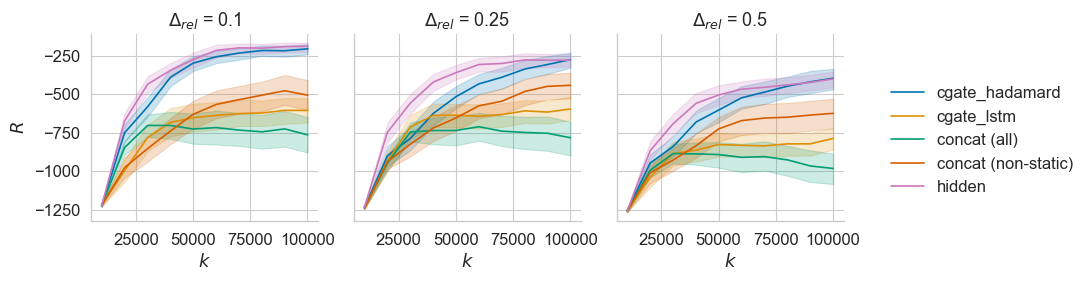

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig_fn = figoutdir / f"{env_name}_differdeltarel.png"

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.35)

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
palette = get_palette_visibility(plot_df)
group_keys = [wandb_key_translator["context_sampler.uniform_bounds_rel"]]

grid = sns.FacetGrid(data=plot_df, col=group_keys[0], legend_out=True)
grid.map_dataframe(sns.lineplot, x=wkt["train/global_step"], y=wkt["eval/return"], hue=wkt["wandb.group"], palette=palette, errorbar=errorbar)
# xticks = np.linspace(0, round(plot_df[wkt["train/global_step"]].max(), -5), 5) # TODO
# grid.set(xticks=xticks)
grid.add_legend()
grid.tight_layout()

grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)

plt.show()


## Grid: Rows: Delta_rel, Cols: Visibility, Hue: CF

/tmp/ipykernel_15785/2140404949.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_15785/2140404949.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_15785/2140404949.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after


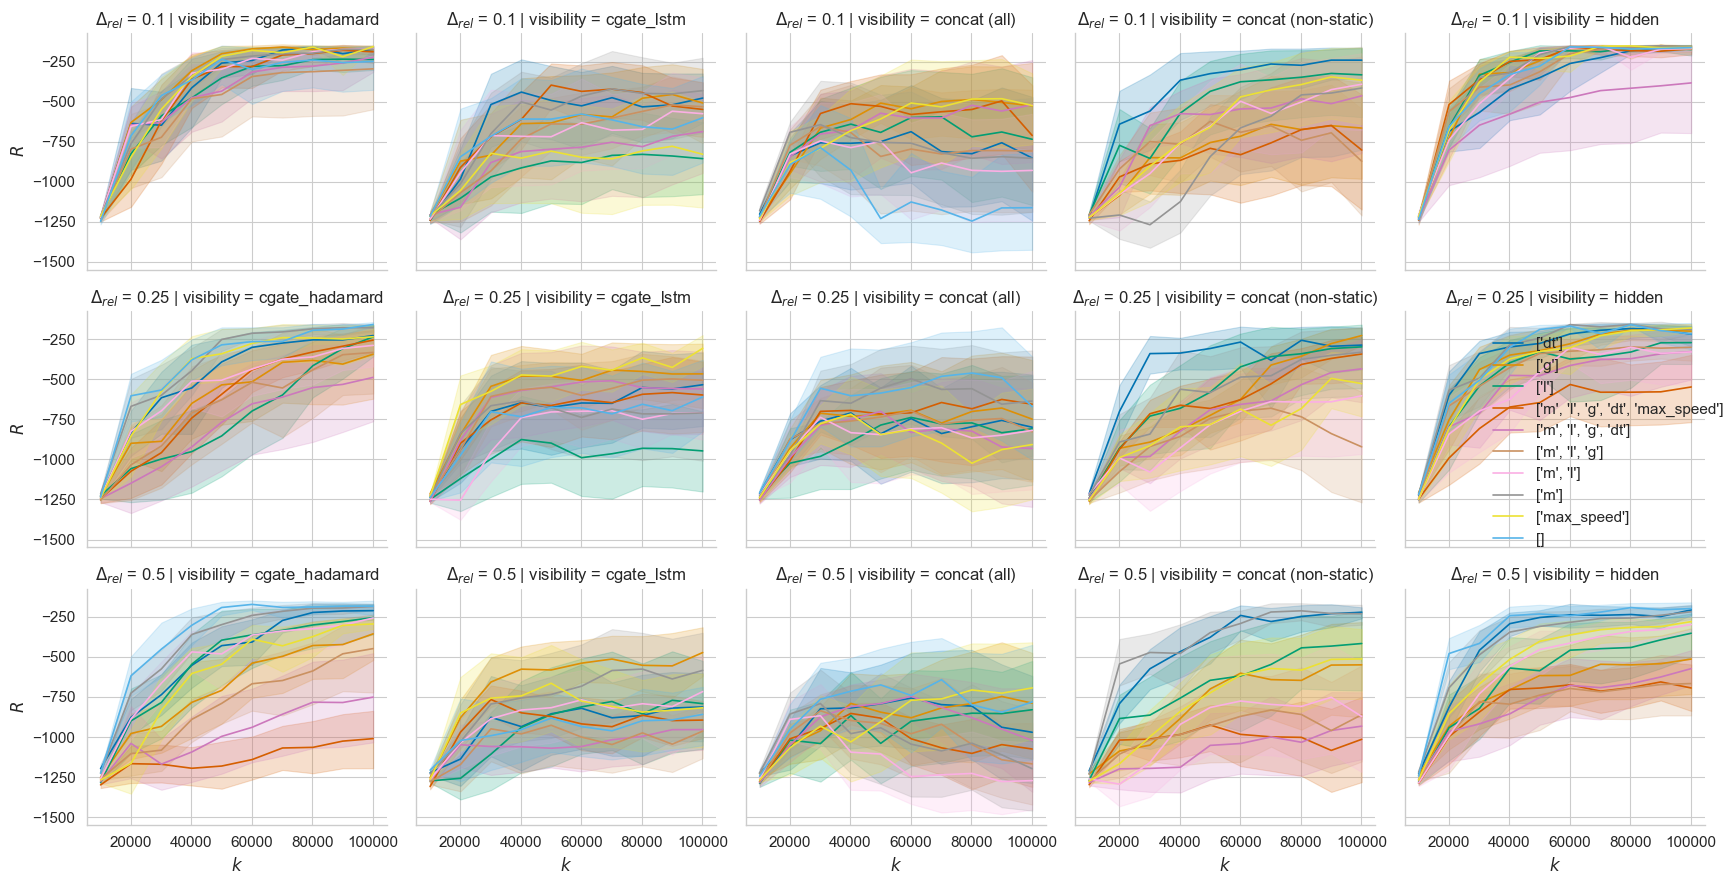

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.25)

fig_fn = figoutdir / f"{env_name}_grid__row_deltarel__col_visibility__hue_cf.png"

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
palette = get_palette_visibility(plot_df)

row = wkt['context_sampler.uniform_bounds_rel']
col = wkt["wandb.group"]
hue = wkt["context_sampler.context_feature_names"]
xname = wkt["train/global_step"]
yname = wkt["eval/return"]

grid = sns.FacetGrid(data=plot_df, row=row, col=col, legend_out=True)
grid.map_dataframe(sns.lineplot, x=xname, y=yname, hue=hue, palette="colorblind")
grid.add_legend()
grid.figure.set_tight_layout(True)
grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)
plt.show()

## Grid: Col: cf, Hue: Visibility

/tmp/ipykernel_15785/2140404949.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_15785/2140404949.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_15785/2140404949.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after


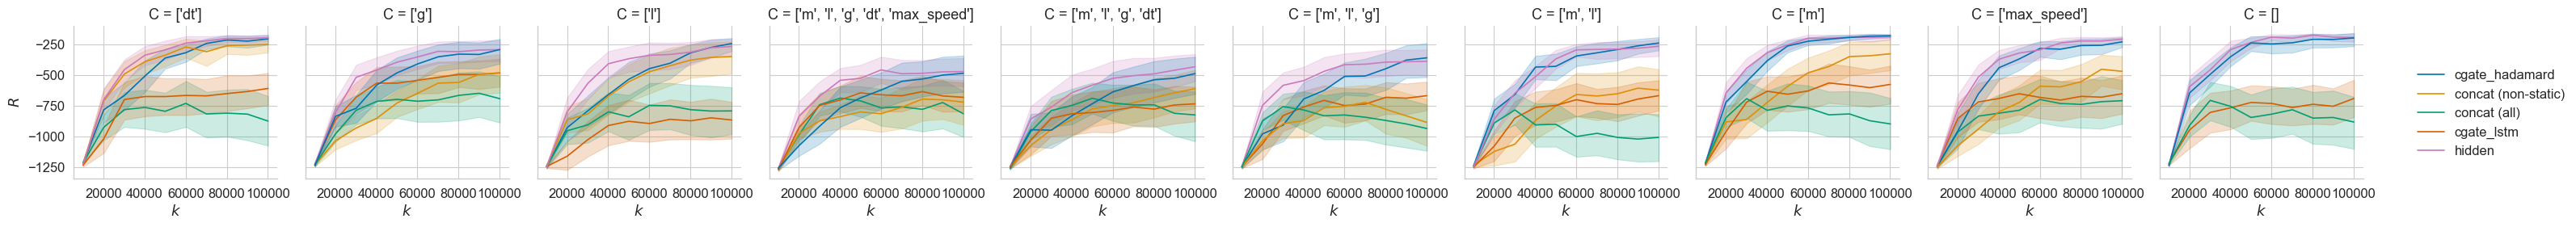

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig_fn = figoutdir / f"{env_name}_grid_col_cf__hue_visibility.png"

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.35)

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
plot_df.sort_values(by=wkt["context_sampler.context_feature_names"], inplace=True)
palette = get_palette_visibility(plot_df)
group_keys = [wandb_key_translator["context_sampler.context_feature_names"]]

grid = sns.FacetGrid(data=plot_df, col=group_keys[0], legend_out=True)
grid.map_dataframe(sns.lineplot, x=wkt["train/global_step"], y=wkt["eval/return"], hue=wkt["wandb.group"], palette=palette, errorbar=errorbar)
# xticks = np.linspace(0, round(plot_df[wkt["train/global_step"]].max(), -5), 5) # TODO
# grid.set(xticks=xticks)
grid.add_legend()
grid.tight_layout()

grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)

plt.show()

## Plot Combined, differ. by sigma

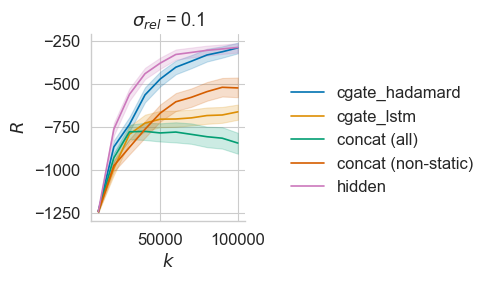

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig_fn = figoutdir / f"{env_name}_differsigma.png"

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.35)

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
if env_name == "CARLBipedalWalkerEnv":
    errorbar = "sd"
    plot_df = plot_df[plot_df[wkt["train/global_step"]] < 500050]

# plot_df = plot_df[plot_df[wkt["wandb.group"]] == "hidden"]
palette = get_palette_visibility(plot_df)
group_keys = [wandb_key_translator["context_sampler.sigma_rel"]]

grid = sns.FacetGrid(data=plot_df, col=group_keys[0], legend_out=True)
grid.map_dataframe(sns.lineplot, x=wkt["train/global_step"], y=wkt["eval/return"], hue=wkt["wandb.group"], palette=palette, errorbar=errorbar)
# xticks = np.linspace(0, round(plot_df[wkt["train/global_step"]].max(), -5), 5) # TODO
# grid.set(xticks=xticks)
grid.add_legend()
grid.tight_layout()

grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)

plt.show()

# if env_name == "CARLPendulumEnv":
#     ylim = (-600, -180)
#     _ = [ax.set_ylim(*ylim) for ax in grid.axes.flatten()]


In [5]:
plot_df[wkt["train/global_step"]].unique()

array([ 10207.,  20155.,  30200., ...,  40356., 100113.,  20407.])

## Grid: Rows: std, Cols: Visibility, Hue: CF

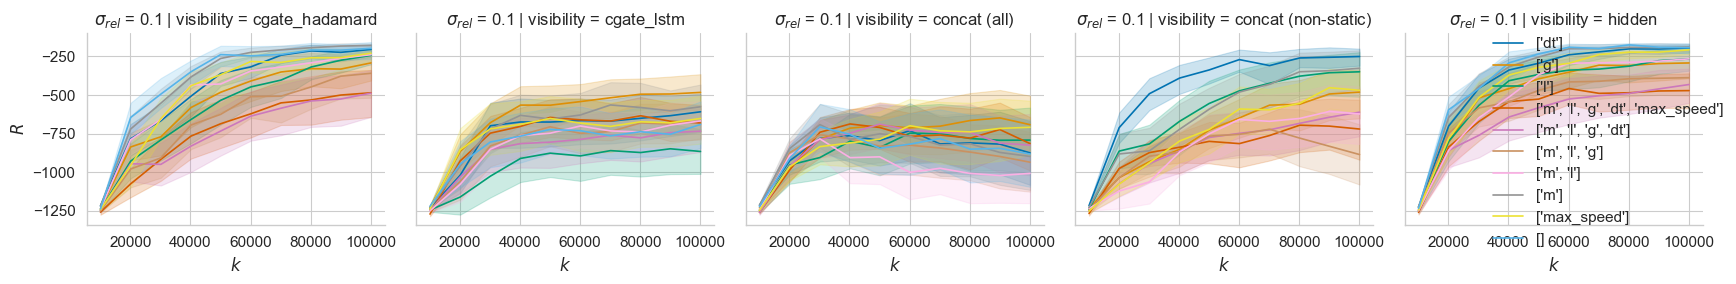

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.25)

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
palette = get_palette_visibility(plot_df)

row = wkt['context_sampler.sigma_rel']
col = wkt["wandb.group"]
hue = wkt["context_sampler.context_feature_names"]
xname = wkt["train/global_step"]
yname = wkt["eval/return"]

grid = sns.FacetGrid(data=plot_df, row=row, col=col, legend_out=True)
grid.map_dataframe(sns.lineplot, x=xname, y=yname, hue=hue, palette="colorblind")
grid.add_legend()
grid.figure.set_tight_layout(True)
plt.show()

## Plot for each sigma, diff grids by changing cf, hue: visibility

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.25)

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
palette = get_palette_visibility(plot_df)
groups = plot_df.groupby(wkt["context_sampler.sigma_rel"])

for group_id, group_df in groups:
    group_keys = [wkt["context_sampler.context_feature_names"]]
    group_df[wkt["context_sampler.context_feature_names"]] = group_df[wkt["context_sampler.context_feature_names"]].apply(ast.literal_eval).apply(tuple)
    group_df = group_df.sort_values(by=[wkt["context_sampler.context_feature_names"]], key=lambda x: [len(xi) for xi in x])
    grid = sns.FacetGrid(data=group_df, col=group_keys[0], legend_out=True)
    grid.map_dataframe(sns.lineplot, x=wkt["train/global_step"], y=wkt["eval/return"], hue=wkt["wandb.group"], palette=palette, errorbar=errorbar)
    xticks = np.linspace(0, round(group_df[wkt["train/global_step"]].max(), -5), 5)
    grid.set(xticks=xticks)
    grid.add_legend(label_order=sorted(group_df[wkt["wandb.group"]].unique()))
    grid.figure.suptitle(f"{wkt['context_sampler.sigma_rel']}={group_id}")
    grid.tight_layout()

    fig_fn = figoutdir / f"{env_name}_differcontextfeatures_{group_id}.png"
    grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig_fn = figoutdir / f"{env_name}_differcontextfeatures_grid.png"

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.2)

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
palette = get_palette_visibility(plot_df)
group_keys = [wandb_key_translator["context_sampler.context_feature_names"], wandb_key_translator["context_sampler.sigma_rel"]]

plot_df[wkt["context_sampler.context_feature_names"]] = plot_df[wkt["context_sampler.context_feature_names"]].apply(
    ast.literal_eval).apply(tuple)
plot_df = plot_df.sort_values(by=[wkt["context_sampler.context_feature_names"]], key=lambda x: [len(xi) for xi in x])

grid = sns.FacetGrid(data=plot_df, col=group_keys[0], row=group_keys[1], legend_out=True)
grid.map_dataframe(sns.lineplot, x=wkt["train/global_step"], y=wkt["eval/return"], hue=wkt["wandb.group"],
                   palette=palette, errorbar=errorbar)
xticks = np.linspace(0, round(plot_df[wkt["train/global_step"]].max(), -5), 5)
grid.set(xticks=xticks)
grid.add_legend(label_order=sorted(group_df[wkt["wandb.group"]].unique()))
grid.tight_layout()

grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig_fn = figoutdir / f"{env_name}_differcontextfeatures.png"

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.25)

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
palette = get_palette_visibility(plot_df)
group_keys = [wandb_key_translator["context_sampler.context_feature_names"]]

plot_df[wkt["context_sampler.context_feature_names"]] = plot_df[wkt["context_sampler.context_feature_names"]].apply(ast.literal_eval).apply(tuple)
plot_df = plot_df.sort_values(by=[wkt["context_sampler.context_feature_names"]], key=lambda x: [len(xi) for xi in x])

grid = sns.FacetGrid(data=plot_df, col=group_keys[0], legend_out=True)
grid.map_dataframe(sns.lineplot, x=wkt["train/global_step"], y=wkt["eval/return"], hue=wkt["wandb.group"], palette=palette, errorbar=errorbar)
xticks = np.linspace(0, round(plot_df[wkt["train/global_step"]].max(), -5), 5)
grid.set(xticks=xticks)
grid.add_legend(label_order=sorted(group_df[wkt["wandb.group"]].unique()))
grid.tight_layout()

grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)

plt.show()

# if env_name == "CARLPendulumEnv":
#     ylim = (-600, -180)
#     _ = [ax.set_ylim(*ylim) for ax in grid.axes.flatten()]


## Plot for each sigma, diff grids by changing cf, hue: visibility

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.35)

plot_df = load_plot_df(plot_data_fn=plot_data_fn)
palette = get_palette_visibility(plot_df)
plot_df[wkt["context_sampler.context_feature_names"]] = plot_df[wkt["context_sampler.context_feature_names"]].apply(ast.literal_eval).apply(tuple)
plot_df = plot_df.sort_values(by=[wkt["context_sampler.context_feature_names"]], key=lambda x: [len(xi) for xi in x])
groups = plot_df.groupby(wkt["context_sampler.context_feature_names"])

for group_id, group_df in groups:
    group_keys = [wkt["context_sampler.sigma_rel"]]
    grid = sns.FacetGrid(data=group_df, col=group_keys[0], legend_out=True)
    grid.map_dataframe(sns.lineplot, x=wkt["train/global_step"], y=wkt["eval/return"], hue=wkt["wandb.group"], palette=palette, errorbar=errorbar)
    xticks = np.linspace(0, round(plot_df[wkt["train/global_step"]].max(), -5), 5)
    grid.set(xticks=xticks)
    grid.add_legend(label_order=sorted(group_df[wkt["wandb.group"]].unique()))
    grid.figure.suptitle(f"{wkt['context_sampler.context_feature_names']} = {group_id}")
    grid.tight_layout()

    fig_fn = figoutdir / f"{env_name}_differcontextfeatures_{group_id}.png"
    grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)
    plt.show()

## Last Evaluation

/tmp/ipykernel_3051/1260046923.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_3051/1260046923.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_3051/1260046923.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after


(
    array(['cgate_hadamard', 'concat (non-static)', 'hidden'], dtype=object),
    array([180, 150, 180])
)

180

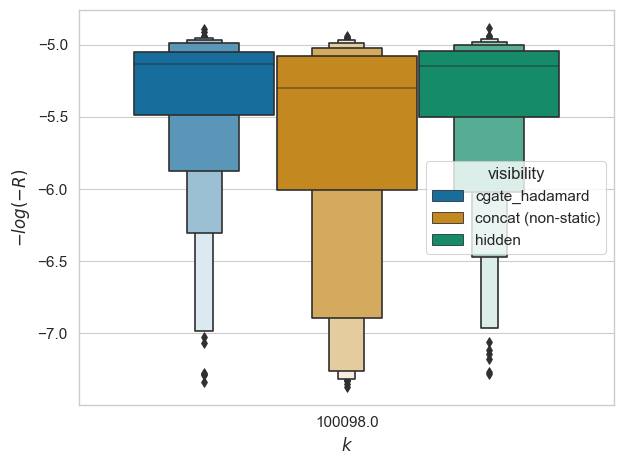

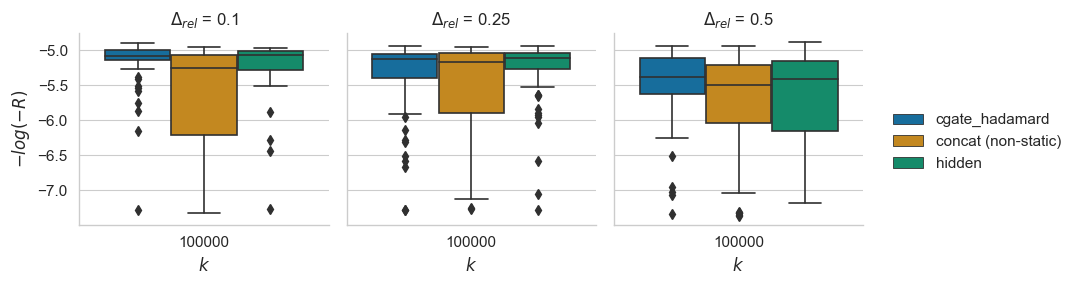

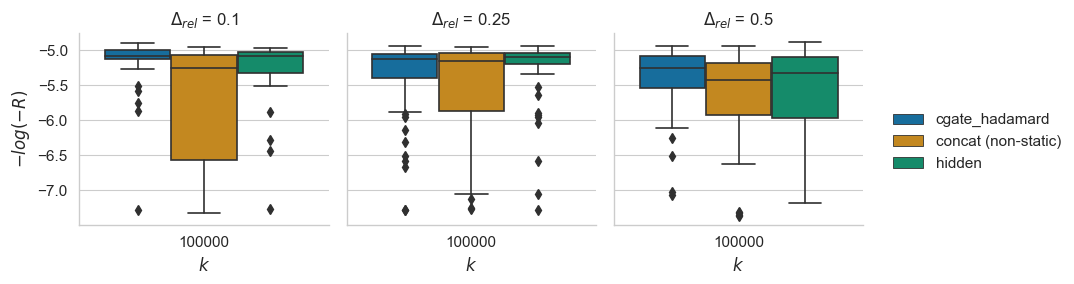

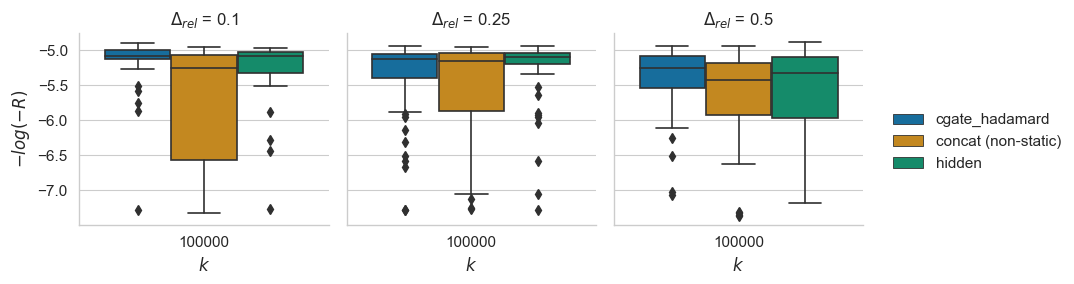

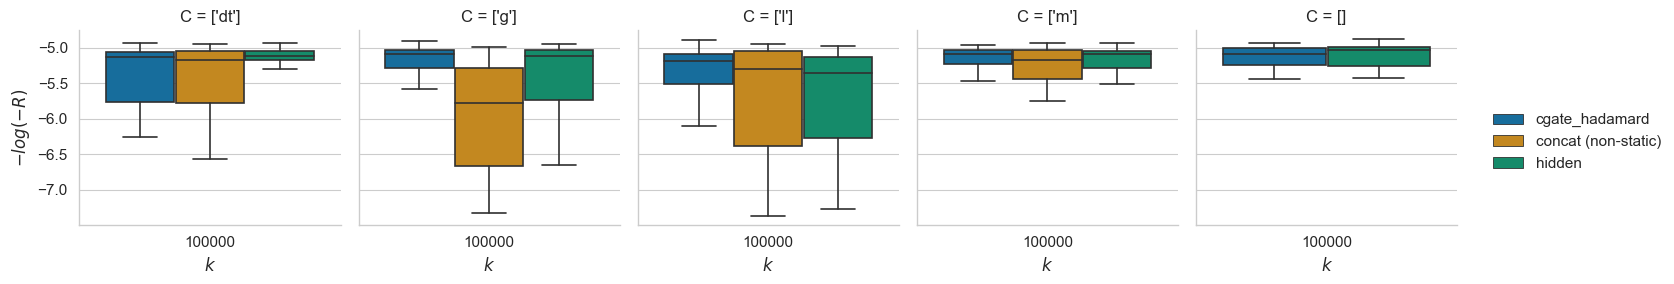

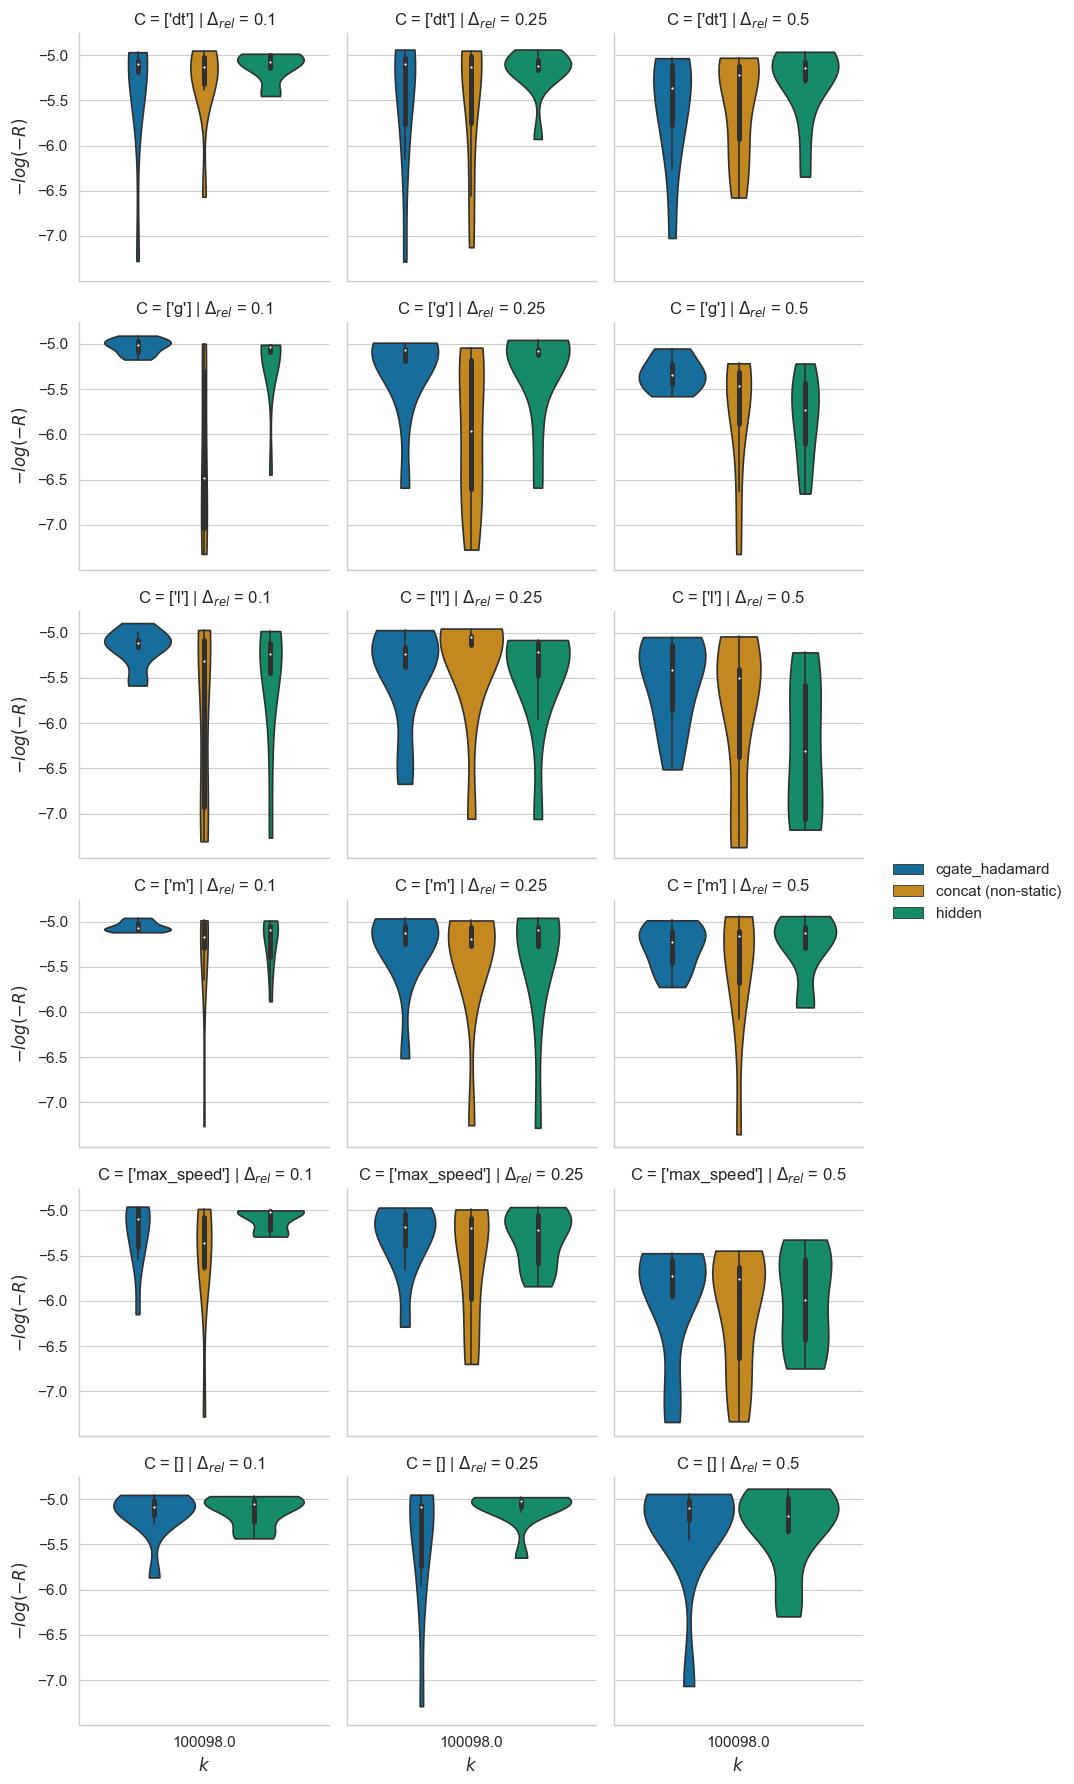

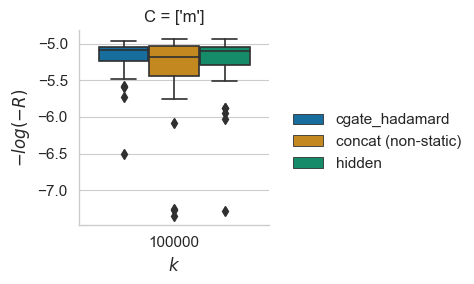

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plot_df = load_plot_df(plot_data_fn=plot_data_fn, load_final=True)

key = wkt["wandb.group"]
plot_df = plot_df[(plot_df[key] == "hidden") | (plot_df[key] == "cgate_hadamard") | (plot_df[key] == "concat (non-static)")]

printr(np.unique(plot_df["visibility"], return_counts=True))
printr(len(plot_df[plot_df["visibility"] == "cgate_hadamard"]))

ylog = True
ylabel = "$R$"


# Prepare dataset
ynameplot = wkt["eval/return"] 
if ylog:
    ylabel = "$- log(-R)$"
    ynameplot += "_scaled_log"
    Y = plot_df[wkt["eval/return"]].copy()
    Y *= -1
    Y = np.log(Y)
    Y *= -1
    plot_df[ynameplot] = Y

# Plotting style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.25)
palette = get_palette_visibility(plot_df)

# Plot aggregated
fig_fn = figoutdir / f"{env_name}_deltarel_boxenplot.png"
fig = plt.figure()
ax = fig.add_subplot(111)
ax = sns.boxenplot(data=plot_df, x=wkt["train/global_step"], y=ynameplot, hue=wkt["wandb.group"], palette=palette, showfliers=True)#, cut=0)
xticklabels = [str(int(round(plot_df[wkt["train/global_step"]].max(), -5)))]
#ax.set_xticklabels(xticklabels)
ax.set_ylabel(ylabel)
fig.set_tight_layout(True)
fig.savefig(fig_fn, dpi=300, bbox_inches="tight")
plt.show()

# Plot per delta rel
fig_fn = figoutdir / f"{env_name}_differdeltarel_boxplot.png"
group_keys = [wandb_key_translator["context_sampler.uniform_bounds_rel"]]

row = None
col = group_keys[0]

grid = sns.FacetGrid(data=plot_df, row=row, col=col, legend_out=True)
grid.map_dataframe(sns.boxplot, x=wkt["train/global_step"], y=ynameplot, hue=wkt["wandb.group"], palette=palette)#, cut=0)
grid.add_legend()
xticklabels = [str(int(round(plot_df[wkt["train/global_step"]].max(), -5)))]
grid.set_xticklabels(xticklabels)
grid.set_ylabels(ylabel)
grid.tight_layout()
grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)
plt.show()


# Plot per delta rel, only single variations
fig_fn = figoutdir / f"{env_name}_differdeltarel_boxplot_singlevar.png"
group_keys = [wandb_key_translator["context_sampler.uniform_bounds_rel"]]

row = None
col = group_keys[0]

key = wkt["context_sampler.context_feature_names"]
subdf = plot_df[[len(cf) <= 6 for cf in plot_df[key]]]

grid = sns.FacetGrid(data=subdf, row=row, col=col, legend_out=True)
grid.map_dataframe(sns.boxplot, x=wkt["train/global_step"], y=ynameplot, hue=wkt["wandb.group"], palette=palette)#, cut=0)
grid.add_legend()
xticklabels = [str(int(round(plot_df[wkt["train/global_step"]].max(), -5)))]
grid.set_xticklabels(xticklabels)
grid.set_ylabels(ylabel)
grid.tight_layout()
grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)
plt.show()


# Plot per delta rel, only single variations, no lstm/concat all
fig_fn = figoutdir / f"{env_name}_differdeltarel_boxplot_singlevar_nolstmconcatall.png"
group_keys = [wandb_key_translator["context_sampler.uniform_bounds_rel"]]

row = None
col = group_keys[0]

key = wkt["context_sampler.context_feature_names"]
subdf = plot_df[[len(cf) <= 6 for cf in plot_df[key]]]
subdf = subdf[(subdf[wkt["wandb.group"]] != "cgate_lstm") & (subdf[wkt["wandb.group"]] != "concat (all)")]

grid = sns.FacetGrid(data=subdf, row=row, col=col, legend_out=True)
grid.map_dataframe(sns.boxplot, x=wkt["train/global_step"], y=ynameplot, hue=wkt["wandb.group"], palette=palette)#, cut=0)
grid.add_legend()
xticklabels = [str(int(round(plot_df[wkt["train/global_step"]].max(), -5)))]
grid.set_xticklabels(xticklabels)
grid.set_ylabels(ylabel)
grid.tight_layout()
grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)
plt.show()


# Plot per cf, only single variations
fig_fn = figoutdir / f"{env_name}_differdeltarel_boxplot_singlevar_percf.png"

key = wkt["context_sampler.context_feature_names"]
subdf = plot_df[[len(cf) <= 6 for cf in plot_df[key]]]

row = None
col = key
showfliers = False

grid = sns.FacetGrid(data=subdf, row=row, col=col, legend_out=True)
grid.map_dataframe(sns.boxplot, x=wkt["train/global_step"], y=ynameplot, hue=wkt["wandb.group"], palette=palette, showfliers=showfliers)#, cut=0)
grid.add_legend()
xticklabels = [str(int(round(plot_df[wkt["train/global_step"]].max(), -5)))]
grid.set_xticklabels(xticklabels)
grid.set_ylabels(ylabel)
grid.tight_layout()
grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)
plt.show()

# Plot per delta rel and cf
fig_fn = figoutdir / f"{env_name}_differdeltarel_differcf_violinplot.png"
col = group_keys[0]
row = wkt["context_sampler.context_feature_names"]
group_keys = [wandb_key_translator["context_sampler.uniform_bounds_rel"]]
grid = sns.FacetGrid(data=plot_df, row=row, col=col, legend_out=True)
grid.map_dataframe(sns.violinplot, x=wkt["train/global_step"], y=ynameplot, hue=wkt["wandb.group"], palette=palette, cut=0)
grid.add_legend()
xticklabels = [str(int(round(plot_df[wkt["train/global_step"]].max(), -5)))]
#grid.set_xticklabels(xticklabels)
grid.set_ylabels(ylabel)
grid.tight_layout()
grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)
plt.show()



# Plot compounding
fig_fn = figoutdir / f"{env_name}_differdeltarel_compounding.png"
col = wkt["context_sampler.context_feature_names"]
row = None
order = ["['m']", "['m', 'l']", "['m', 'l', 'g']", "['m', 'l', 'g', 'dt']", "['m', 'l', 'g', 'dt', 'max_speed']"]
key = wkt["context_sampler.context_feature_names"]
subdf = plot_df[[cf in order for cf in plot_df[key]]]
subdf = subdf.sort_values(by=key, ascending=False)
grid = sns.FacetGrid(data=subdf, row=row, col=col, legend_out=True, row_order=order)
grid.map_dataframe(sns.boxplot, x=wkt["train/global_step"], y=ynameplot, hue=wkt["wandb.group"], hue_order=list(palette.keys()), palette=palette)  #, cut=0)
grid.add_legend()
xticklabels = [str(int(round(plot_df[wkt["train/global_step"]].max(), -5)))]
grid.set_xticklabels(xticklabels)
grid.set_ylabels(ylabel)
grid.tight_layout()
grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)
plt.show()


#############################################

# # Plot per sigma
# fig_fn = figoutdir / f"{env_name}_differsigma_violinplot.png"
# group_keys = [wandb_key_translator["context_sampler.sigma_rel"]]

# row = None
# col = group_keys[0]

# grid = sns.FacetGrid(data=plot_df, row=row, col=col, legend_out=True)
# grid.map_dataframe(sns.boxplot, x=wkt["train/global_step"], y=ynameplot, hue=wkt["wandb.group"], palette=palette)#, cut=0)
# grid.add_legend()
# xticklabels = [str(int(round(plot_df[wkt["train/global_step"]].max(), -5)))]
# grid.set_xticklabels(xticklabels)
# grid.set_ylabels("$R$")
# grid.tight_layout()
# grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)
# plt.show()

# # Plot per sigma and cf
# fig_fn = figoutdir / f"{env_name}_differsigma_differcf_violinplot.png"
# col = group_keys[0]
# row = wkt["context_sampler.context_feature_names"]

# group_keys = [wandb_key_translator["context_sampler.sigma_rel"]]
# grid = sns.FacetGrid(data=plot_df, row=row, col=col, legend_out=True)
# grid.map_dataframe(sns.violinplot, x=wkt["train/global_step"], y=ynameplot, hue=wkt["wandb.group"], palette=palette, cut=0)
# grid.add_legend()
# xticklabels = [str(int(round(plot_df[wkt["train/global_step"]].max(), -5)))]
# grid.set_xticklabels(xticklabels)
# grid.set_ylabels("$R$")
# grid.tight_layout()
# grid.figure.savefig(fig_fn, bbox_inches="tight", dpi=300)
# plt.show()

## Plot Final Eval (Avg over Seed)

/tmp/ipykernel_9723/3111174406.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_9723/3111174406.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after
/tmp/ipykernel_9723/3111174406.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df[key][plot_df[key] == before] = after


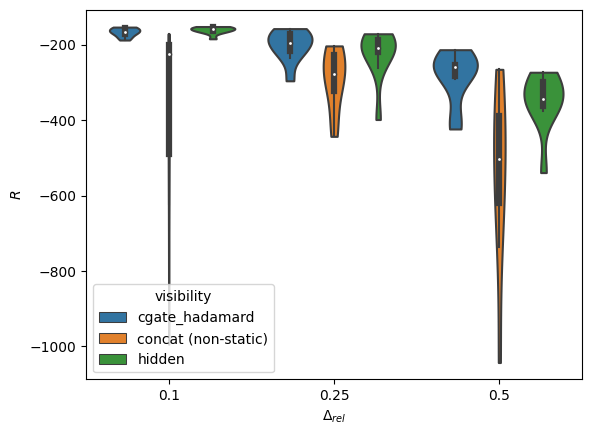

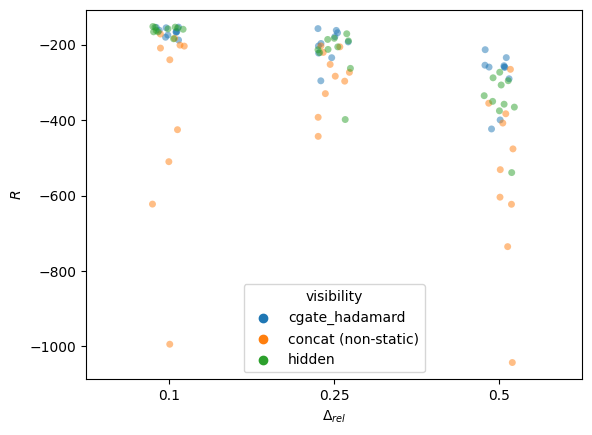

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

plot_df = load_plot_df(plot_data_fn=plot_data_fn, load_final=True)

key = wkt["wandb.group"]
plot_df = plot_df[(plot_df[key] == "hidden") | (plot_df[key] == "cgate_hadamard") | (plot_df[key] == "concat (non-static)")]

reduced = plot_df.groupby([wkt["wandb.group"], wkt["context_sampler.uniform_bounds_rel"], "seed"])[wkt["eval/return"]].mean(numeric_only=True)
reduced = plot_df.groupby([wkt["wandb.group"], wkt["context_sampler.uniform_bounds_rel"], "seed"])[wkt["eval/return"]].apply(scipy.stats.trim_mean, proportiontocut=0.25, axis=None)
reduced = reduced.reset_index()  # multi-index (groups) back to normal columns

# reduced = plot_df

hue = wkt["wandb.group"]
x = wkt["context_sampler.uniform_bounds_rel"]
y = wkt["eval/return"]
ax = sns.violinplot(data=reduced, x=x, y=y, hue=hue, multiple="dodge", cut=0)

plt.show()
ax = sns.stripplot(data=reduced, x=x, y=y,hue=hue, alpha=0.5)


In [ ]:
subdf[wkt["wandb.group"]].unique()

In [18]:
subdf[key].unique()
plot_df[key].unique()

array(["['dt']", "['g']", "['l']", "['m', 'l', 'g', 'dt', 'max_speed']",
       "['m', 'l', 'g', 'dt']", "['m', 'l', 'g']", "['m', 'l']", "['m']",
       "['max_speed']", '[]'], dtype=object)

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been

['cgate_hadamard', 'concat (non-static)', 'concat (all)', 'cgate_lstm', 'hidden']


/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


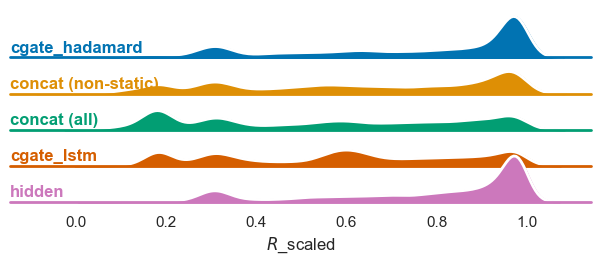

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

plot_df = scale(plot_df, yname=wkt["eval/return"], log=False)

ynameplot = wkt["eval/return"] + "_scaled"

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
pal = get_palette_visibility(plot_df)
g = sns.FacetGrid(plot_df, row=wkt["wandb.group"], hue=wkt["wandb.group"], aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map_dataframe(sns.kdeplot, x=ynameplot,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5, palette=pal)
g.map_dataframe(sns.kdeplot, x=ynameplot, clip_on=False, color="w", lw=2, bw_adjust=.5, palette=pal)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)
# g.map(label, "x")

visibilities = list(g.axes_dict.keys())
for vis, ax in g.axes_dict.items():
      color = pal[vis]
      label = vis
      ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

print(visibilities)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

# Plot Aggregated

CARLAcrobotEnv
1 6
2 6
3 6
4 6
5 6
6 6
7 6
8 6
9 6
10 6
concat (all) (6, 10)
1 5
2 6
3 6
4 6
5 6
6 6
7 6
8 6
9 6
10 6
hidden (6, 10)


/tmp/ipykernel_24346/330555281.py:82: UserWarning: Imputing missing task evals with nan
  warnings.warn("Imputing missing task evals with nan")


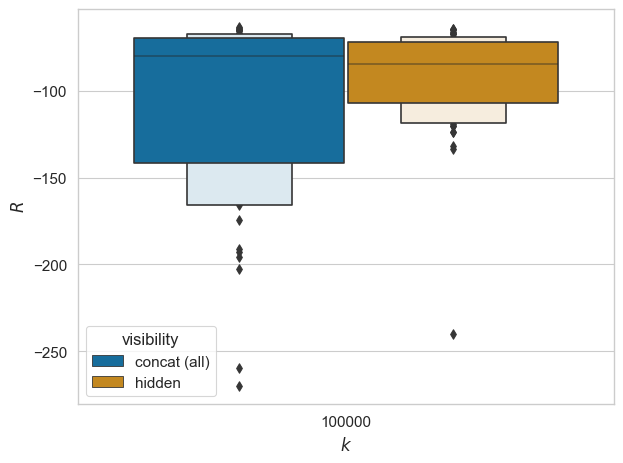

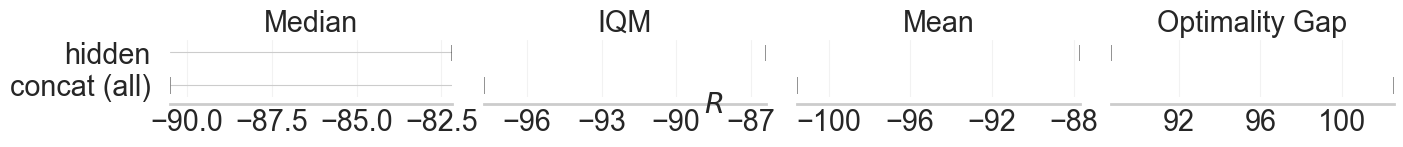

CARLDmcWalkerEnv
1 5
2 5
3 5
4 5
5 5
6 5
7 5
8 5
9 5
10 5
concat (all) (6, 10)
1 5
2 5
3 5
4 5
5 5
6 5
7 5
8 5
9 5
10 5
hidden (6, 10)


/tmp/ipykernel_24346/330555281.py:82: UserWarning: Imputing missing task evals with nan
  warnings.warn("Imputing missing task evals with nan")
/tmp/ipykernel_24346/330555281.py:82: UserWarning: Imputing missing task evals with nan
  warnings.warn("Imputing missing task evals with nan")


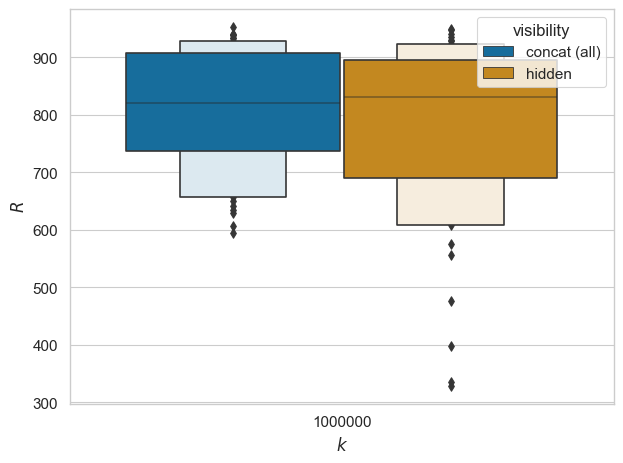

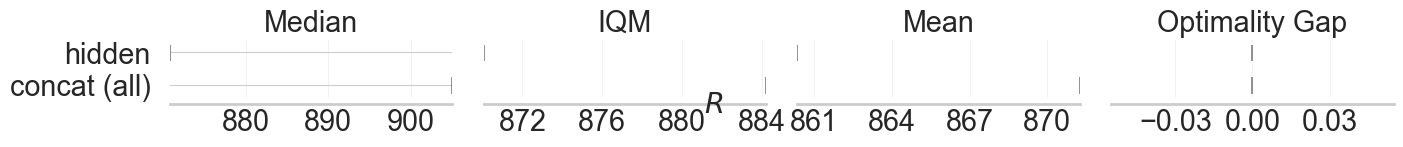

CARLDmcQuadrupedEnv
1.0 3
2.0 3
3.0 3
4.0 3
5.0 3
6.0 3
7.0 3
8.0 3
9.0 3
10.0 3
concat (all) (6, 10)
1.0 3
2.0 3
3.0 3
4.0 3
5.0 3
6.0 3
7.0 3
8.0 3
9.0 3
10.0 3
hidden (6, 10)


/tmp/ipykernel_24346/330555281.py:82: UserWarning: Imputing missing task evals with nan
  warnings.warn("Imputing missing task evals with nan")
/tmp/ipykernel_24346/330555281.py:82: UserWarning: Imputing missing task evals with nan
  warnings.warn("Imputing missing task evals with nan")


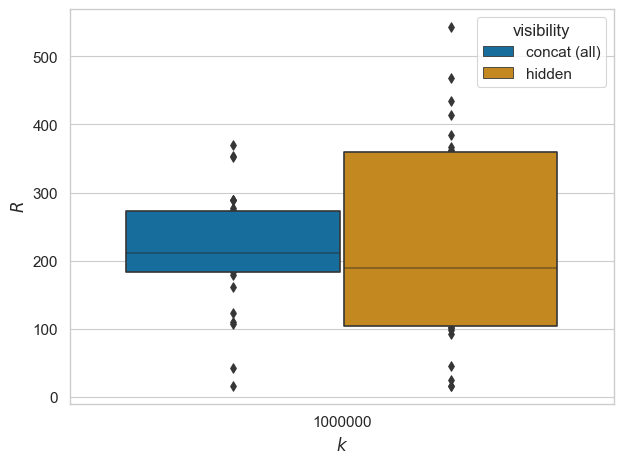

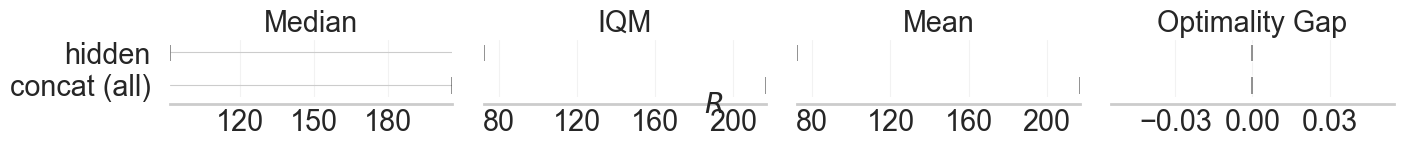

CARLMountainCarEnv
1 5
2 5
3 5
4 5
5 5
6 5
7 5
8 5
9 5
10 5
concat (all) (6, 10)
1 5
2 5
3 5
4 5
5 5
6 4
7 5
8 5
9 5
10 5
hidden (6, 10)


/tmp/ipykernel_24346/330555281.py:82: UserWarning: Imputing missing task evals with nan
  warnings.warn("Imputing missing task evals with nan")
/tmp/ipykernel_24346/330555281.py:82: UserWarning: Imputing missing task evals with nan
  warnings.warn("Imputing missing task evals with nan")


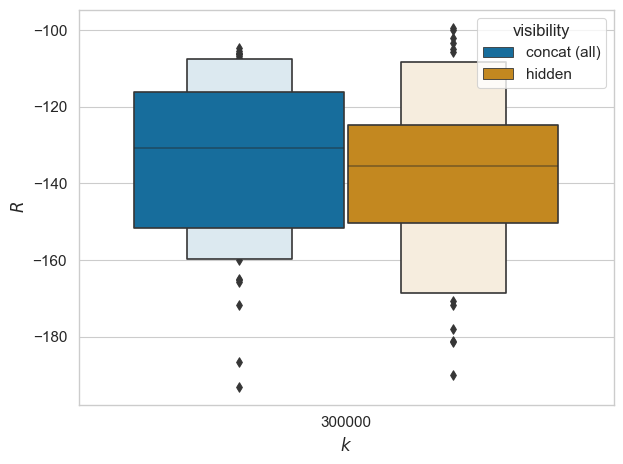

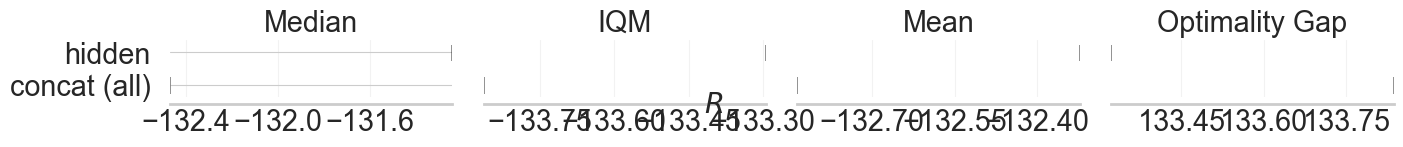

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import warnings


# Prepare dataset
ynameplot = wkt["eval/return"] #+ "_scaled_log"

# Plotting style
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.25)


# Plot aggregated
def plot_aggregated_boxenplot(plot_df: pd.DataFrame, env_name: str, figoutdir: Path, yname: str, palette=None, ):
    if palette is None:
        palette = get_palette_visibility(plot_df)
    fig_fn = figoutdir / f"{env_name}_boxenplot.png"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = sns.boxenplot(data=plot_df, x=wkt["train/global_step"], y=yname, hue=wkt["wandb.group"], palette=palette, showfliers=True)#, cut=0)
    # ax = sns.violinplot(data=plot_df, x=wkt["train/global_step"], y=yname, hue=wkt["wandb.group"], palette=palette, cut=0)
    xticklabels = [str(int(round(plot_df[wkt["train/global_step"]].max(), -5)))]
    ax.set_xticklabels(xticklabels)
    ax.set_ylabel(ylabel)
    fig.set_tight_layout(True)
    fig.savefig(fig_fn, dpi=300, bbox_inches="tight")
    plt.show()


metric_names = ['Median', 'IQM', 'Mean', 'Optimality Gap']
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  metrics.aggregate_optimality_gap(x)])



reps = 5000  # 50000



env_names = [
    # "CARLPendulumEnv",
    "CARLAcrobotEnv",
    "CARLDmcWalkerEnv",
    "CARLDmcQuadrupedEnv",
    "CARLMountainCarEnv"
]

for env_name in env_names:
    print(env_name)
    eval_data_fn = get_eval_data_fn(outdir=outdir, env_name=env_name)
    plot_data_fn = get_plot_data_fn(eval_data_fn=eval_data_fn)
    plot_df = load_plot_df(plot_data_fn=plot_data_fn, load_final=True)
    plot_df = plot_df[plot_df[wkt["context_sampler.sigma_rel"]] == 0.5]
    plot_df = plot_df[(plot_df[wkt["wandb.group"]] == "concat (all)") | (plot_df[wkt["wandb.group"]] == "hidden")]



    score_dict = {}
    for group_id, group_df in plot_df.groupby("visibility"):
        wide = group_df[[wkt["eval/return"], wkt["seed"]]]
        # seeds are ordered
        n_seeds = wide["seed"].nunique()
        # we want shape (n_tasks, n_seeds)
        # print(wide.to_numpy().shape)
        # print(wide.to_numpy().flatten().reshape(n_seeds, -1))

        # we want (n_seeds, n_tasks)
        n_tasks = 6
        scores = []
        for gid, gdf in group_df.groupby("seed"):
            print(gid, len(gdf))
            S = gdf[wkt["eval/return"]].to_numpy()
            if len(S) < n_tasks:
                warnings.warn("Imputing missing task evals with nan")
                n_impute = n_tasks - len(S)
                impute = [np.nan] * n_impute
                S = np.array(list(S) + impute)
            scores.append(S)
        scores = np.array(scores).T
        print(group_id, scores.shape)

        scores = gdf[wkt["eval/return"]].to_numpy().reshape(1, -1)

        score_dict[group_id] = scores  

    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        score_dict, aggregate_func, reps=reps)


    plot_aggregated_boxenplot(plot_df=plot_df, env_name=env_name, figoutdir=figoutdir, yname=ynameplot)


    fig, axes = plot_utils.plot_interval_estimates(
        aggregate_scores, aggregate_score_cis,
        metric_names=metric_names,
        algorithms=algorithms, xlabel=wkt["eval/return"])
    # fig.set_tight_layout(True)
    plt.show()

    # break

In [21]:
int(round(plot_df["$k$"].unique().mean(), -5))

100000